# Get number plate from image

In [ ]:
!pip install easyocr

In [4]:
import cv2
import imutils
import numpy as np
import easyocr
import matplotlib.pyplot as plt

In [5]:
# Loading image
img = 'car.jpg'

In [6]:
# Reading image
image = cv2.imread(img)
# Resizing image
image = imutils.resize(image, width=960)
# Converting to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Reducing noise
gray = cv2.bilateralFilter(gray, 10, 16, 16)
# Detecting edges
edged = cv2.Canny(gray, 30, 200)

In [7]:
# Finding contours
keypoints = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [8]:
# Find countors that make a rectangle
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [9]:
# Blank everything but the area of interest
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0, 255, -1)
new_image = cv2.bitwise_and(image, image, mask=mask)

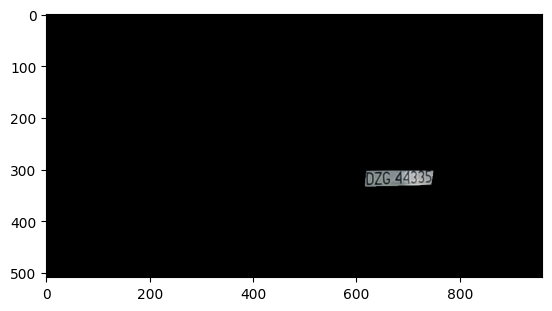

In [10]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [11]:
# Cropp image
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2, y1:y2]

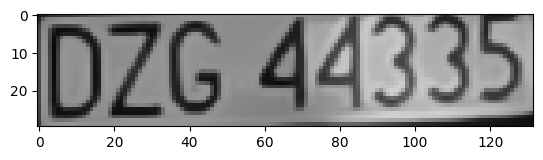

In [12]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [13]:
# Read text
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
print(f'Number plate data:\n{result}')

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteNumber plate data:
[([[0, 0], [132, 0], [132, 30], [0, 30]], 'DZG 44335', 0.8894344668542835)]


# Send request for number plate information

In [14]:
from bs4 import BeautifulSoup
import urllib.request
import re

In [15]:
# Remove whitespaces
plate = result[0][1]
plate = plate.replace(' ', '')

In [16]:
# Send request
req = urllib.request.Request(f'https://tablica-rejestracyjna.pl/{plate}')
page = urllib.request.urlopen(req)
soup = BeautifulSoup(page.read(), 'html.parser')

In [17]:
# Registered in
region = soup.find_all('span', {'itemprop': 'name'})
try:
    voivodeship = region[0].text.title()
except Exception:
    voivodeship = 'N/A'

try:
    powiat = region[1].text.title()
except Exception:
    powiat = 'N/A'

In [18]:
# Car
car = soup.find('span', {'itemprop': 'description'})
try:
    car = car.text
except Exception:
    car = 'N/A'

In [19]:
# Driver like and Dislike
thumbs_up = soup.find('div', {'id': 'cnt1'})
thumbs_down = soup.find('div', {'id': 'cnt-1'})
try:
    thumbs_up = thumbs_up.text.strip()
    thumbs_down = thumbs_down.text.strip()
except Exception:
    thumbs_up = 'N/A'
    thumbs_down = 'N/A'

In [20]:
# Rating history
rating_history = soup.find('ul', {'class': 'ratingHistory'})
history = []
try:
    for rating in rating_history:
        history.append(rating.text)
except Exception:
    history.append('N/A')

In [21]:
# Get comments
comments = soup.find_all('div', class_='comment')

# Get upvotes from every comment
upvotes_list = []
for comment in comments:
    upvotes_list.extend(comment.find_all('meta', {'itemprop': 'upvoteCount'}))

# Get the integers from upvotes_list
upvote_numbers = []
pattern = r'\d+'
for item in upvotes_list:
    # Convert item to string and search for pattern
    match = re.search(pattern, str(item))
    if match:
        # Convert matched string to integer and append to list
        upvote_numbers.append(int(match.group()))

# Get number of downvotes from every comment
downvotes_list = []
for comment in comments:
    downvotes_list.extend(comment.find_all('meta', {'itemprop': 'downvoteCount'}))

# Get the integers from downvotes_list
downvote_numbers = []
pattern = r'\d+'
for item in downvotes_list:
    # Convert item to string and search for pattern
    match = re.search(pattern, str(item))
    if match:
        # Convert matched string to integer and append to list
        downvote_numbers.append(int(match.group()))

# Subtract lists to get the real score of the comment
subtract = []
for i in range(len(upvote_numbers)):
    subtract.append(upvote_numbers[i]-downvote_numbers[i])

In [22]:
# Get data from highest score comment
try:
    highest_score_index = subtract.index(max(subtract))

    # Comment
    highest_score_comment = comments[highest_score_index].find('span', {'class': 'text'})
    highest_score_comment = highest_score_comment.text.replace('\r', '').replace('\n', '')

    # Time posted
    highest_score_time = comments[highest_score_index].find('span', {'class': 'date'})
    highest_score_time = highest_score_time.text
except Exception:
    highest_score_comment = 'N/A'
    highest_score_image_link = 'N/A'
    highest_score_time = 'N/A'

In [23]:
# Get data from lowest score comment only if is different then highest score comment
try:
    lowest_score_index = subtract.index(min(subtract))
    if lowest_score_index != highest_score_index:
        # Comment
        lowest_score_comment = comments[lowest_score_index].find('span', {'class': 'text'})
        lowest_score_comment = lowest_score_comment.text.replace('\r', '').replace('\n', '')

        # Time posted
        lowest_score_time = comments[lowest_score_index].find('span', {'class': 'date'})
        lowest_score_time = lowest_score_time.text
except Exception:
    lowest_score_comment = 'N/A'
    lowest_score_image_link = 'N/A'
    lowest_score_time = 'N/A'

# Render scraped data

In [24]:
from jinja2 import Template
from IPython.display import display, HTML

# Load the HTML template
template = Template('''
<!DOCTYPE html>
<html>
<head>
    <title>Variable Example</title>
    <!-- Add Bootstrap CSS -->
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css">
    <style>
        /* Custom CSS */
        body {
            font-size: 18px;
        }
    </style>
</head>
<body>
    <div class="container">
        <h3>Województwo: {{ voivodeship }}</h3>
        <hr>
        <h3>Powiat: {{ powiat }}</h3>
        <hr>
        <h3>Car: {{ car }}</h3>
        <hr>
        <h3>Like: {{ thumbs_up }}</h3>
        <hr>
        <h3>Dislike: {{ thumbs_down }}</h3>
        <hr>
        <h3>Rating History:</h3>
        <ul>
            {% for rating in history %}
            <li>{{ rating }}</li>
            {% endfor %}
        </ul>
        <hr>
        <h3>Highest Scored Comment:</h3>
        <br>
        <h3>Time posted:</h3>
        <p>{{ highest_score_time }}</p>
        <h3>Comment:</h3>
        <p>{{ highest_score_comment }}</p>
        <h3>Score:</h3>
        <p>
            {{ subtract[highest_score_index] }}
        </p>
        <hr>
        <h3>Lowest Scored Comment:</h3>
        <br>
        <h3>Time posted:</h3>
        <p>{{ lowest_score_time }}</p>
        <h3>Comment:</h3>
        <p>{{ lowest_score_comment }}</p>
        <h3>Score:</h3>
        <p>
            {{ subtract[lowest_score_index] }}
        </p>
    </div>

    <!-- Add Bootstrap JavaScript (optional, but required for certain features) -->
    <script src="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/js/bootstrap.min.js"></script>
</body>
</html>
''')

# Render the template with the variables
rendered_template = template.render(
    voivodeship=voivodeship,
    powiat=powiat,
    car=car,
    thumbs_up=thumbs_up,
    thumbs_down=thumbs_down,
    history=history,
    highest_score_time=highest_score_time,
    highest_score_comment=highest_score_comment,
    highest_score_index=highest_score_index,
    subtract=subtract,
    lowest_score_time=lowest_score_time,
    lowest_score_comment=lowest_score_comment,
    lowest_score_index=lowest_score_index
)

display(HTML(rendered_template))